In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import json
import math
from itertools import combinations
import random

In [34]:
# import data
origin_df = pd.read_csv('transactions_n100000.csv')
cust_id = set(origin_df.ticket_id)
len(cust_id) #100,000 unique ids

100000

In [35]:
# extract order_time to time_period
origin_df['order_timestamp'] = pd.to_datetime(origin_df['order_timestamp'])
hour_list = [record.hour for record in origin_df.order_timestamp]
origin_df['hour']=hour_list

In [36]:
# extract item_name
item_df = origin_df.pivot_table(index=['ticket_id'], columns=['item_name'], values='item_count')
item_df = item_df.fillna(0).reset_index()
process_1 = pd.merge(origin_df,item_df)
process_1 = process_1[['ticket_id','location','lat','long','hour','burger','fries','salad','shake']]

In [37]:
# extract location information
process_1['geo'] = list(zip(process_1.lat,process_1.long))
geo_seq_set = set(list(zip(process_1.location, process_1.geo)))

geo_seq_dict = {}
for item in geo_seq_set:
    if item not in geo_seq_dict.keys():
        geo_seq_dict[item[1]] = item[0]
    else:
        pass

In [38]:
geo_loc = list(geo_seq_dict.keys())
combo_geo = [*combinations(geo_loc,2)]

lat_long_dict = {}
for item in combo_geo:
    sequence = ( geo_seq_dict[item[0]],geo_seq_dict[item[1]])
    lat_long_dict [sequence] = item

In [39]:
# here we use Haversine Formula to calculate the relative distances between each location
R = 6373.0 # radius of earth
geo_dist_dict = {}
for k, v in lat_long_dict.items():
    dlon = v[1][1] - v[0][1]
    dlat = v[1][0] - v[0][0]
    # Haversine Formula   
    a = math.sin(dlat / 2)**2 + math.cos(v[0][0]) * math.cos(v[1][0]) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    geo_dist_dict[k] = distance    

In [40]:
location_list = list(process_1.location)

In [41]:
# use location 1 as the centroid of the whole
# using the mapping function in Tableau, you will find out location 1 is the city center of Chicago
central_dist_dict = {}
for key in geo_dist_dict.keys():
    if 1  in key:
        central_dist_dict.setdefault(key)
        central_dist_dict[key]=geo_dist_dict[key]

In [42]:
distance_list = []
for record in location_list:
    if record == 1:
        distance_list.append(0)
    else:
        for key in central_dist_dict.keys():
            if record in key:
                distance_list.append(central_dist_dict[key])

In [43]:
process_1['distance'] = distance_list
process_2 = pd.pivot_table(process_1,index='ticket_id')

In [44]:
process_2=process_2[['hour','distance','burger','fries','salad', 'shake']]

In [45]:
period = []
for record in process_2.hour:
    if record <5 or record >20:
        period.append('late supper')
    elif record > 5 and record <=15:
        period.append('lunch')
    else:
        period.append('supper')

process_2['period']=period

In [46]:
process_3 = process_2.drop(['hour'],axis=1)

In [47]:
process_3 = process_3.reset_index()

In [48]:
# dummpy variable
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

time_period =process_3.period 

In [49]:
X = np.asarray(time_period).reshape(-1,1)
meal_type_df = pd.DataFrame(enc.fit_transform(X).toarray())
meal_type_df['ticket_id']=process_3.ticket_id

process_4 = pd.merge(process_3,meal_type_df)
process_4 =process_4.drop(['period',2],axis=1)
process_4.columns = ['cust_id','distance','burger','fries','salad','shake','late_supper','lunch']
cluster_df = process_4[['burger','fries','salad','shake','distance','late_supper','lunch']]

In [50]:
cluster_df.head(5)

,burger,fries,salad,shake,distance,late_supper,lunch
0,1.0,1.0,0.0,0.0,2435.737363,1.0,0.0
1,2.0,2.0,0.0,0.0,618.682404,1.0,0.0
2,4.0,5.0,1.0,4.0,2435.737363,0.0,0.0
3,1.0,1.0,0.0,0.0,618.682404,1.0,0.0
4,3.0,3.0,0.0,3.0,1081.135527,0.0,0.0


In [51]:
# cluster time
X = np.asarray(cluster_df)
scaler = StandardScaler()
X_scale = scaler.fit(X).transform(X)

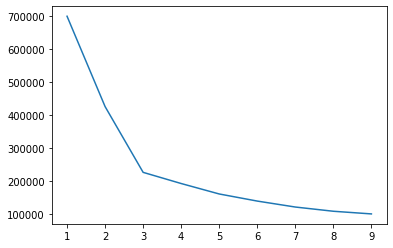

In [31]:
sse=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i,init='k-means++',)
    kmeans.fit(X_scale)
    sse.append(kmeans.inertia_)
    
sn.lineplot(range(1,10),sse)

# so here we choose 3 clusters as our optimal clusters
# more details about those clusters will be presented in our slides using data visualization